<a href="https://colab.research.google.com/github/sarnavadatta/Predictive-Modelling/blob/main/XGBoost_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/DS projects/Machine Learning/XGBoost/'

'Wholesale customers data.csv'	'XGBoost Classifier.ipynb'  'XGBoost Regressor.ipynb'


In [ ]:
df = pd.read_csv('/content/drive/My Drive/DS projects/Machine Learning/XGBoost/Wholesale customers data.csv')
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


Overview:
The dataset includes a **Channel** variable that categorizes customers based on their purchasing behavior. This variable contains two distinct values:

- **1** → Horeca (Hotel/Retail/Café) Customers  
- **2** → Retail Channel (Nominal) Customers  

These values are used to classify customers into their respective channels, allowing the model to learn patterns and make accurate predictions.


In [ ]:
df.shape

(440, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


Check for missing values

In [ ]:
df.isnull().sum()

,0
Channel,0
Region,0
Fresh,0
Milk,0
Grocery,0
Frozen,0
Detergents_Paper,0
Delicassen,0


**Feature & Target Variable**

In [ ]:
X = df.drop('Channel', axis=1)
y = df['Channel']

Convert the 'Channel' into 0 and 1 for further analysis.

In [ ]:
y[y == 2] = 0
y[y == 1] = 1

y.head()

,Channel
0,0
1,0
2,0
3,1
4,0


Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Create separate **DMatrix** for training and testing.


*   xgb.DMatrix is an optimized data structure used by XGBoost for training.
*   It efficiently stores features and labels, reducing memory usage and improving computation speed.
*   This transformation is particularly useful for handling missing values and optimizing matrix operations.





In [ ]:
import xgboost as xgb

dtrain_clf = xgb.DMatrix(data=X_train, label=y_train)
dtest_clf = xgb.DMatrix(data=X_test, label=y_test)

### **Train XGBoost Classifier**

### Parameters:
The model is configured with the following hyperparameters:
- **objective**: `'binary:logistic'` → Specifies that this is a binary classification problem.
- **max_depth**: `4` → Limits the depth of each decision tree to prevent overfitting.
- **alpha**: `10` → L1 regularization term to reduce model complexity.
- **learning_rate**: `1.0` → Controls how much each tree contributes to the final prediction (higher values lead to faster learning but risk overshooting).
- **n_estimators**: `100` → Number of boosting rounds (trees).

### Training Process:
The model is trained using `xgb.train()` with:
- **Training Data (`dtrain_clf`)** → Used to build the model.
- **Test Data (`dtest_clf`)** → Used for evaluation.
- **num_boost_round=500** → The maximum number of boosting rounds (trees).
- **evals=[(dtrain_clf, 'train'), (dtest_clf, 'test')]** → Enables monitoring of model performance on both training and test sets.
- **verbose_eval=10** → Logs evaluation metrics every 10 iterations.
- **early_stopping_rounds=10** → Stops training if the test set performance does not improve for 10 consecutive rounds.

### Notes:
- **Early stopping** prevents overfitting by stopping training when further iterations no longer improve performance.
- The final model is selected based on the best validation performance.


In [ ]:
# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }

# Train the model using xgb.train()
xgb_clf = xgb.train(
    params=params,
    dtrain=dtrain_clf,
    num_boost_round=500,
    evals=[(dtrain_clf, 'train'), (dtest_clf, 'test')],
    verbose_eval=10,
    early_stopping_rounds=10
)

[0]	train-logloss:0.28439	test-logloss:0.35211
[10]	train-logloss:0.22113	test-logloss:0.31465
[11]	train-logloss:0.22113	test-logloss:0.31465


### **Prediction Process:**
1. **Generate Predictions:**
   - `y_pred = xgb_clf.predict(dtest_clf)`
   - The model outputs probabilities between 0 and 1, representing the likelihood of belonging to the positive class.

2. **Convert Probabilities to Binary Predictions:**
   - Since this is a binary classification task, probabilities are converted into class labels:
     - `1` if the probability is **≥ 0.5**  
     - `0` otherwise  

### **Evaluation Metrics:**
- **Accuracy Score:**  
  - `accuracy_score(y_test, y_pred)` calculates the proportion of correctly classified instances.
  - Printed as: `"Accuracy:", accuracy`

- **Confusion Matrix:**  
  - `confusion_matrix(y_test, y_pred)` provides a summary of correct and incorrect classifications:
    - **True Positives (TP)**: Correctly predicted positive cases.
    - **True Negatives (TN)**: Correctly predicted negative cases.
    - **False Positives (FP)**: Incorrectly predicted positive cases.
    - **False Negatives (FN)**: Incorrectly predicted negative cases.


In [ ]:
# prompt: Make predictions with XGBoost Classifier

y_pred = xgb_clf.predict(dtest_clf)

# # Convert probabilities to binary predictions (0 or 1)
y_pred = [1 if pred >= 0.5 else 0 for pred in y_pred]

from sklearn.metrics import accuracy_score, confusion_matrix
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 0.8727272727272727
Confusion Matrix:
 [[30 10]
 [ 4 66]]


# Visualize Confusion Matrix using Seaborn

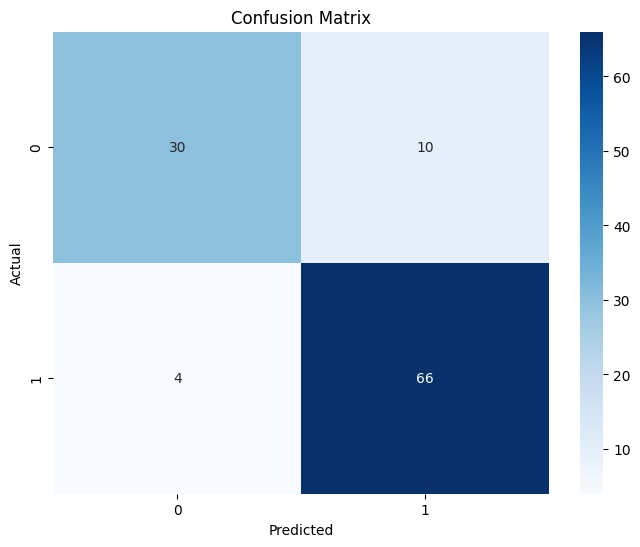

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**K-Fold Cross Validation**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

# Convert data into DMatrix format
dtrain_clf = xgb.DMatrix(data=X_train, label=y_train)

# Declare parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators': 100
}

# Number of boosting rounds
num_boost_round = 500

# Number of K-folds
n_splits = 5  # You can adjust this number as needed

# Perform K-fold cross-validation using xgb.cv
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain_clf,
    num_boost_round=num_boost_round,
    nfold=n_splits,  # K-fold cross-validation
    early_stopping_rounds=10,  # Stop early if no improvement
    verbose_eval=10,  # Display progress every 10 rounds
    metrics="error"  # Evaluation metric to track (e.g., 'error' for classification accuracy)
)

# Output the best number of boosting rounds based on cross-validation
print(f"Best number of boosting rounds: {cv_results.shape[0]}")


[0]	train-error:0.06515+0.01207	test-error:0.10606+0.03833
[9]	train-error:0.06515+0.01207	test-error:0.10606+0.03833
Best number of boosting rounds: 1


XGBoost offers a method to assess the importance of each feature in the original dataset by evaluating how frequently each feature is used for splitting across all the boosting trees in the model. This allows us to understand which features contribute the most to the model's decisions.

The importance of features is quantified by the number of times each feature is selected for splitting, and the results can be visualized using a bar chart, with features ranked based on their frequency of occurrence.

To facilitate this, XGBoost provides the `plot_importance()` function, which enables us to visualize the features that have the highest importance scores. This feature of XGBoost not only aids in understanding the model but also serves as a tool for **feature selection**, helping to identify and focus on the most relevant features for the model.



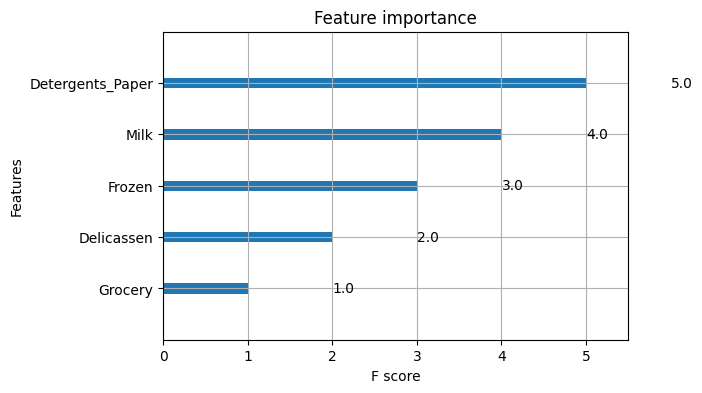

In [ ]:
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()